In [9]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.dataio import *
from utils.visualization import *

DATA_DIR = '../data/'
RESULTS_DIR = '../results_new/'

In [10]:
# Load configuration file.
config = load_config('../config.yaml')

### Numerical phantom

In [11]:
sample_id = 5
task_params = config[f'numerical {sample_id}']
results_path = os.path.join(RESULTS_DIR, task_params['task'])

ip_gt = load_mat(os.path.join(DATA_DIR, task_params['IP']))
sos_gt = load_mat(os.path.join(DATA_DIR, task_params['SOS']))

ip_gt = standardize(ip_gt)
data_range_ip = 15.5 # ip_gt.max() - ip_gt.min()
data_range_sos = 150 # sos_gt.max() - sos_gt.min()

IP_max, IP_min, SOS_max, SOS_min = task_params['IP_max'], task_params['IP_min'], task_params['SOS_max'], task_params['SOS_min']
norm_ip = Normalize(vmax=IP_max, vmin=IP_min)
norm_sos = Normalize(vmax=SOS_max, vmin=SOS_min)

#### Ground Truth

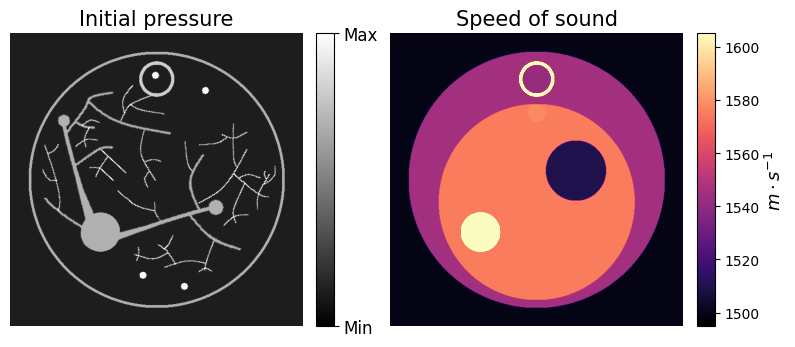

In [12]:
fig = plt.figure(figsize=(9, 3.8))
ax = plt.subplot(1,2,1)
plt.imshow(ip_gt, cmap='gray', norm=norm_ip)
plt.title('Initial pressure', fontsize=15)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_ip)
cb.set_ticks([IP_max, IP_min])
cb.set_ticklabels(['Max', 'Min'], fontsize=12)

ax = plt.subplot(1,2,2)
plt.imshow(sos_gt, cmap='magma', norm=norm_sos)
plt.title('Speed of sound', fontsize=15)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_sos)
cb.set_label('$m \cdot s ^{-1}$', fontsize=13)
plt.savefig(os.path.join('../figures', 'numerical_phantom.png'), bbox_inches='tight')

#### Delay-and-sum

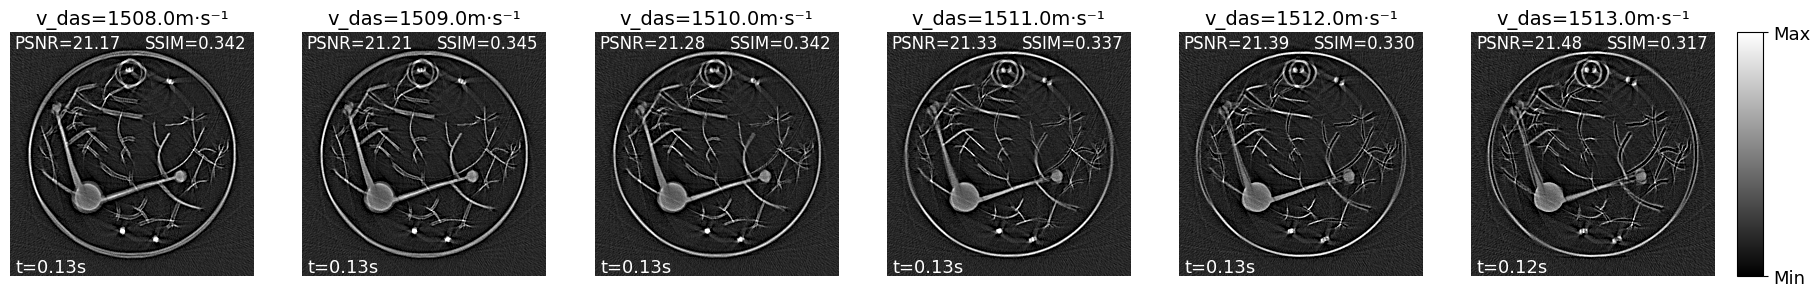

In [13]:
v_das_list = [1508, 1509, 1510, 1511, 1512, 1513, ]

fig = plt.figure(figsize=(22,6))
for idx, v_das in enumerate(v_das_list):
    params = f'v_das={v_das:.1f}m·s⁻¹'
    ip_rec = load_mat(os.path.join(results_path, 'DAS', params, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'DAS', params, 'log.json'))
    ax = plt.subplot(1,len(v_das_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('v_das={:.1f}m·s⁻¹'.format(v_das), fontsize=14)
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=12, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=310, y=35, fontsize=12, color='white')
    plt.text(s='t={:.2f}s'.format(log['time']), x=12, y=550, fontsize=13, color='white')
    if idx == len(v_das_list)-1:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=13)

#### Dual-SOS DAS

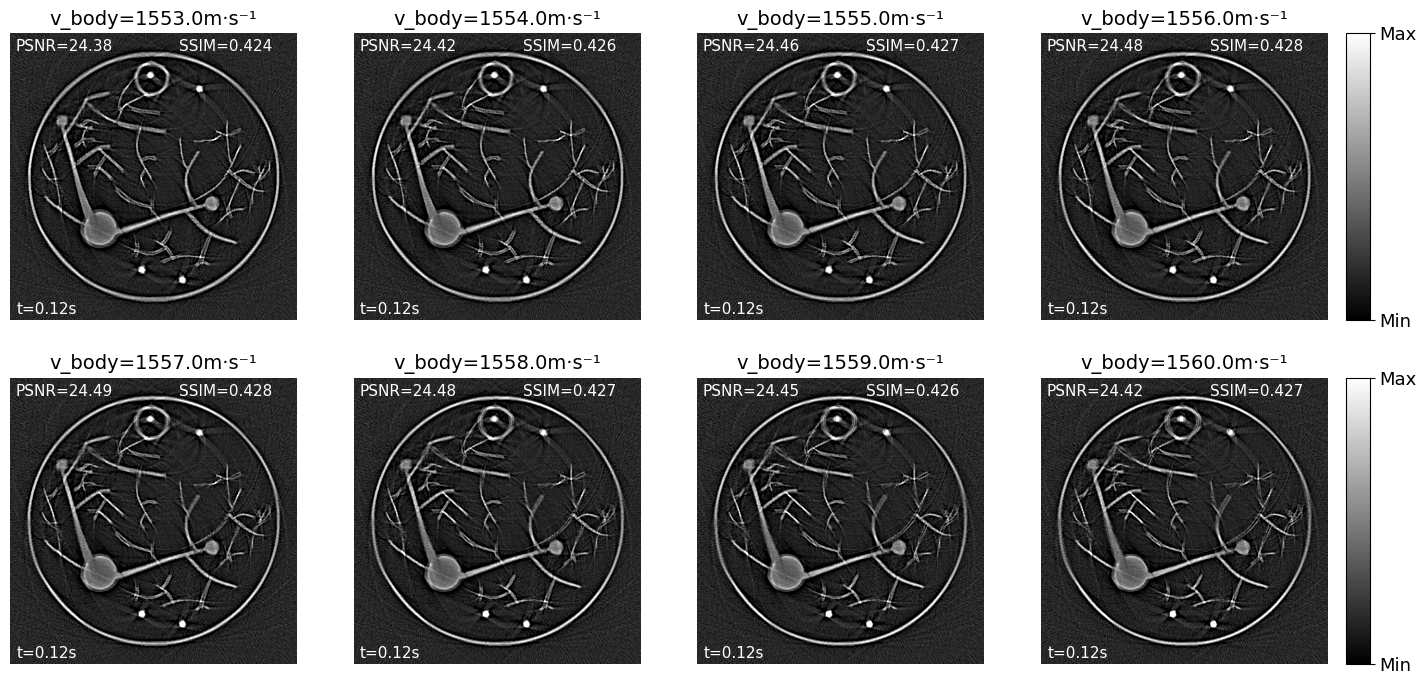

In [14]:
v_body_list = [1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560]
# v_body_list = [1544, 1545, 1546, 1547, 1548, 1549]
# v_body_list = range(1530, 1538)
fig = plt.figure(figsize=(17,8.2))
for idx, v_body in enumerate(v_body_list):
    params = f'v_body={v_body:.1f}m·s⁻¹'
    ip_rec = load_mat(os.path.join(results_path, 'Dual-SOS_DAS', params, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'Dual-SOS_DAS', params, 'log.json'))
    ax = plt.subplot(2,4,idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.title('v_body={:.1f}m·s⁻¹'.format(v_body), fontsize=14)
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.2f}s'.format(log['time']), x=12, y=548, fontsize=11, color='white')
    if not (idx+1) % 4:
        cax = fig.add_axes([ax.get_position().x1+0.011, ax.get_position().y0, 0.014, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=13)

#### NF-APACT

In [15]:
bs_df = 64
lr_nf_df = 5e-3
n_delays_df = 16
hls_df, hfs_df = 0, 256
n_epochs_df = 10

Learning rate.

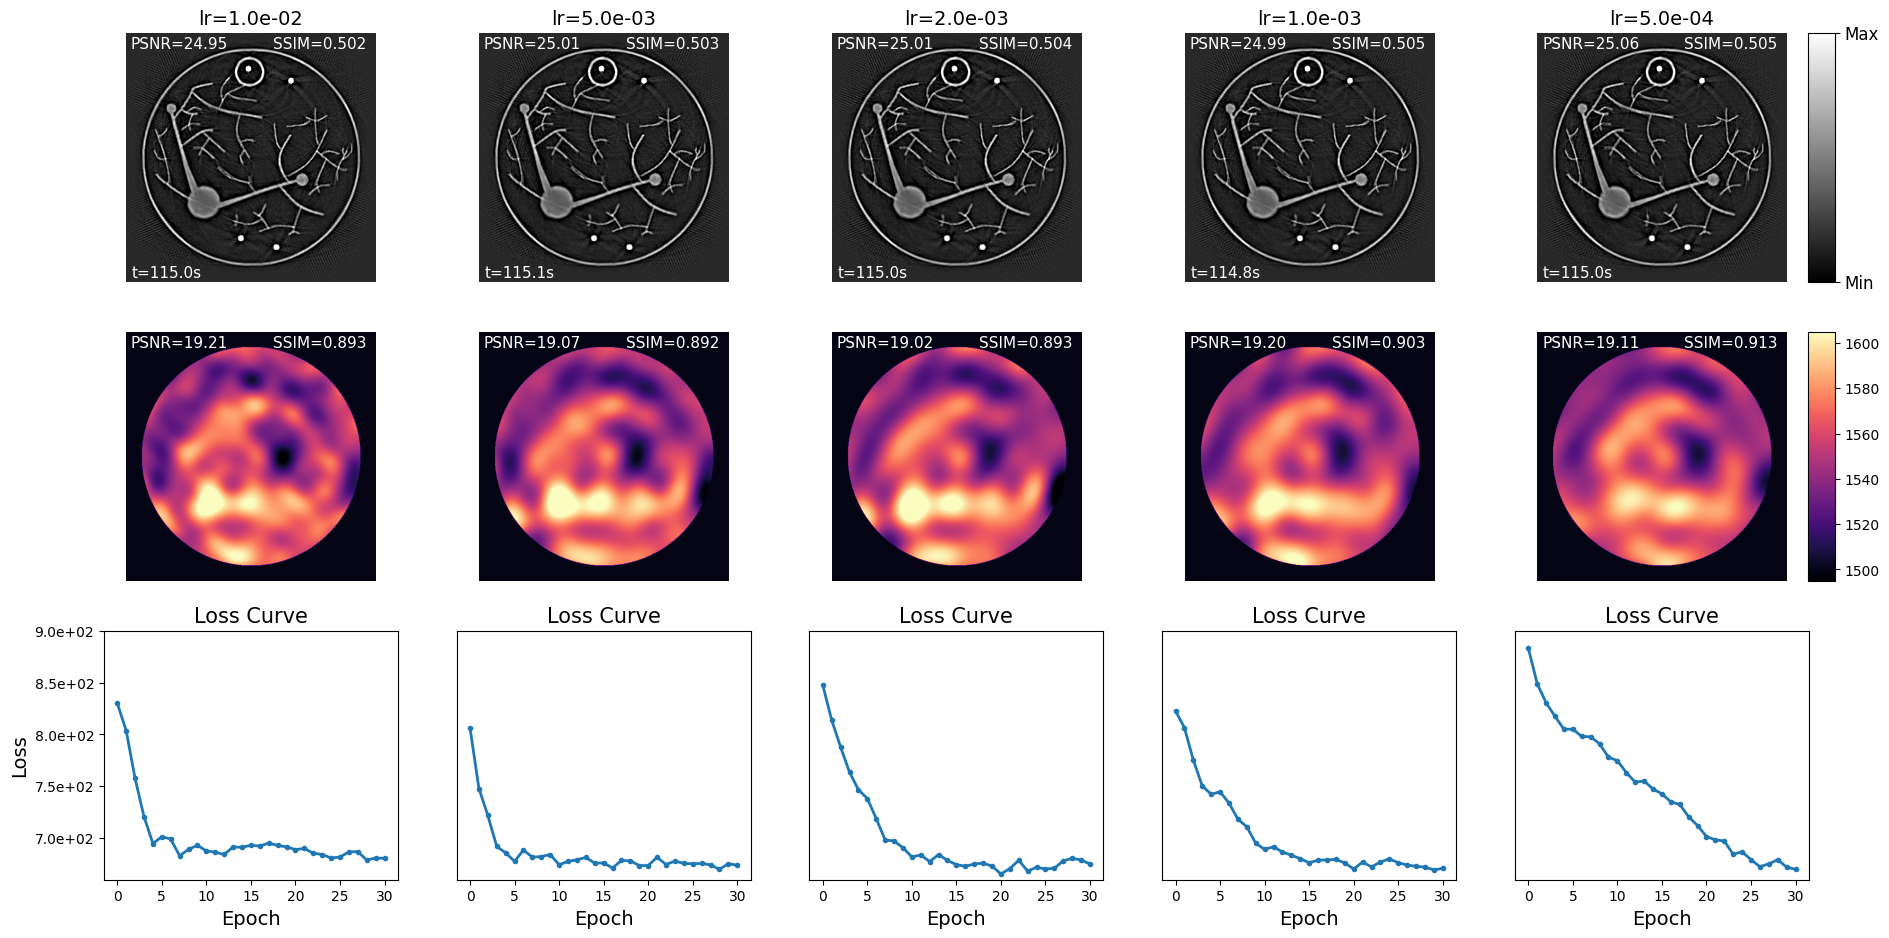

In [16]:
lr_list = [1e-2,5e-3,2e-3,1e-3,5e-4]

fig = plt.figure(figsize=(22,11))
for idx, lr in enumerate(lr_list):
    # params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(32, 1, 64, 1e-4, 30, 64, lr)
    params = f'{n_delays_df}delays_{hls_df}lyrs_{hfs_df}fts_{30}epochs_bs={bs_df}_lr={lr:.1e}'
    ip_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'NF-APACT', params, 'log.json'))
    ax = plt.subplot(3,len(lr_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('lr={:.1e}'.format(lr), fontsize=14)
    if (idx+1) % len(lr_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(3,len(lr_list),idx+1+len(lr_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
    plt.axis('off')
    if (idx+1) % len(lr_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)
        
    ax = plt.subplot(3,len(lr_list),idx+1+2*len(lr_list))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    plt.plot(range(len(log['loss'])), log['loss'], '-o', markersize=3, linewidth=2, label='loss')
    plt.ylim([660, 900])
    plt.title("Loss Curve", fontsize=15)
    plt.xlabel("Epoch", fontsize=14)
    if idx == 0:
        plt.ylabel("Loss", fontsize=14)
    else:
        plt.yticks([])

Number of delays.

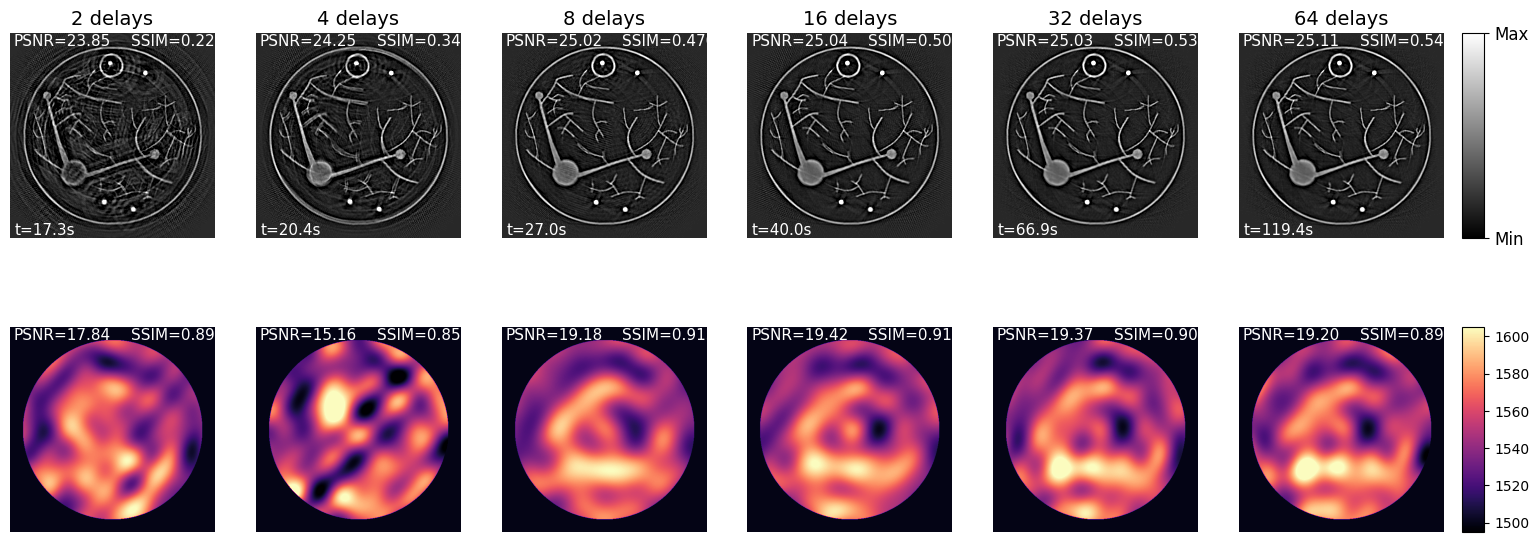

In [17]:
n_delays_list = [2, 4, 8, 16, 32, 64]

fig = plt.figure(figsize=(18.5,7))
for idx, n_delays in enumerate(n_delays_list):
    # params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(n_delays, 1, 64, 1e-4, 10, 64, 1e-3)
    params = f'{n_delays}delays_{hls_df}lyrs_{hfs_df}fts_{n_epochs_df}epochs_bs={bs_df}_lr={lr_nf_df:.1e}'
    ip_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'NF-APACT', params, 'log.json'))
    ax = plt.subplot(2,len(n_delays_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('{} delays'.format(n_delays), fontsize=14)
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(2,len(n_delays_list),idx+1+len(n_delays_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
    plt.axis('off')
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)

Network structure (Positional encoding, number of hidden layers and hidden features).

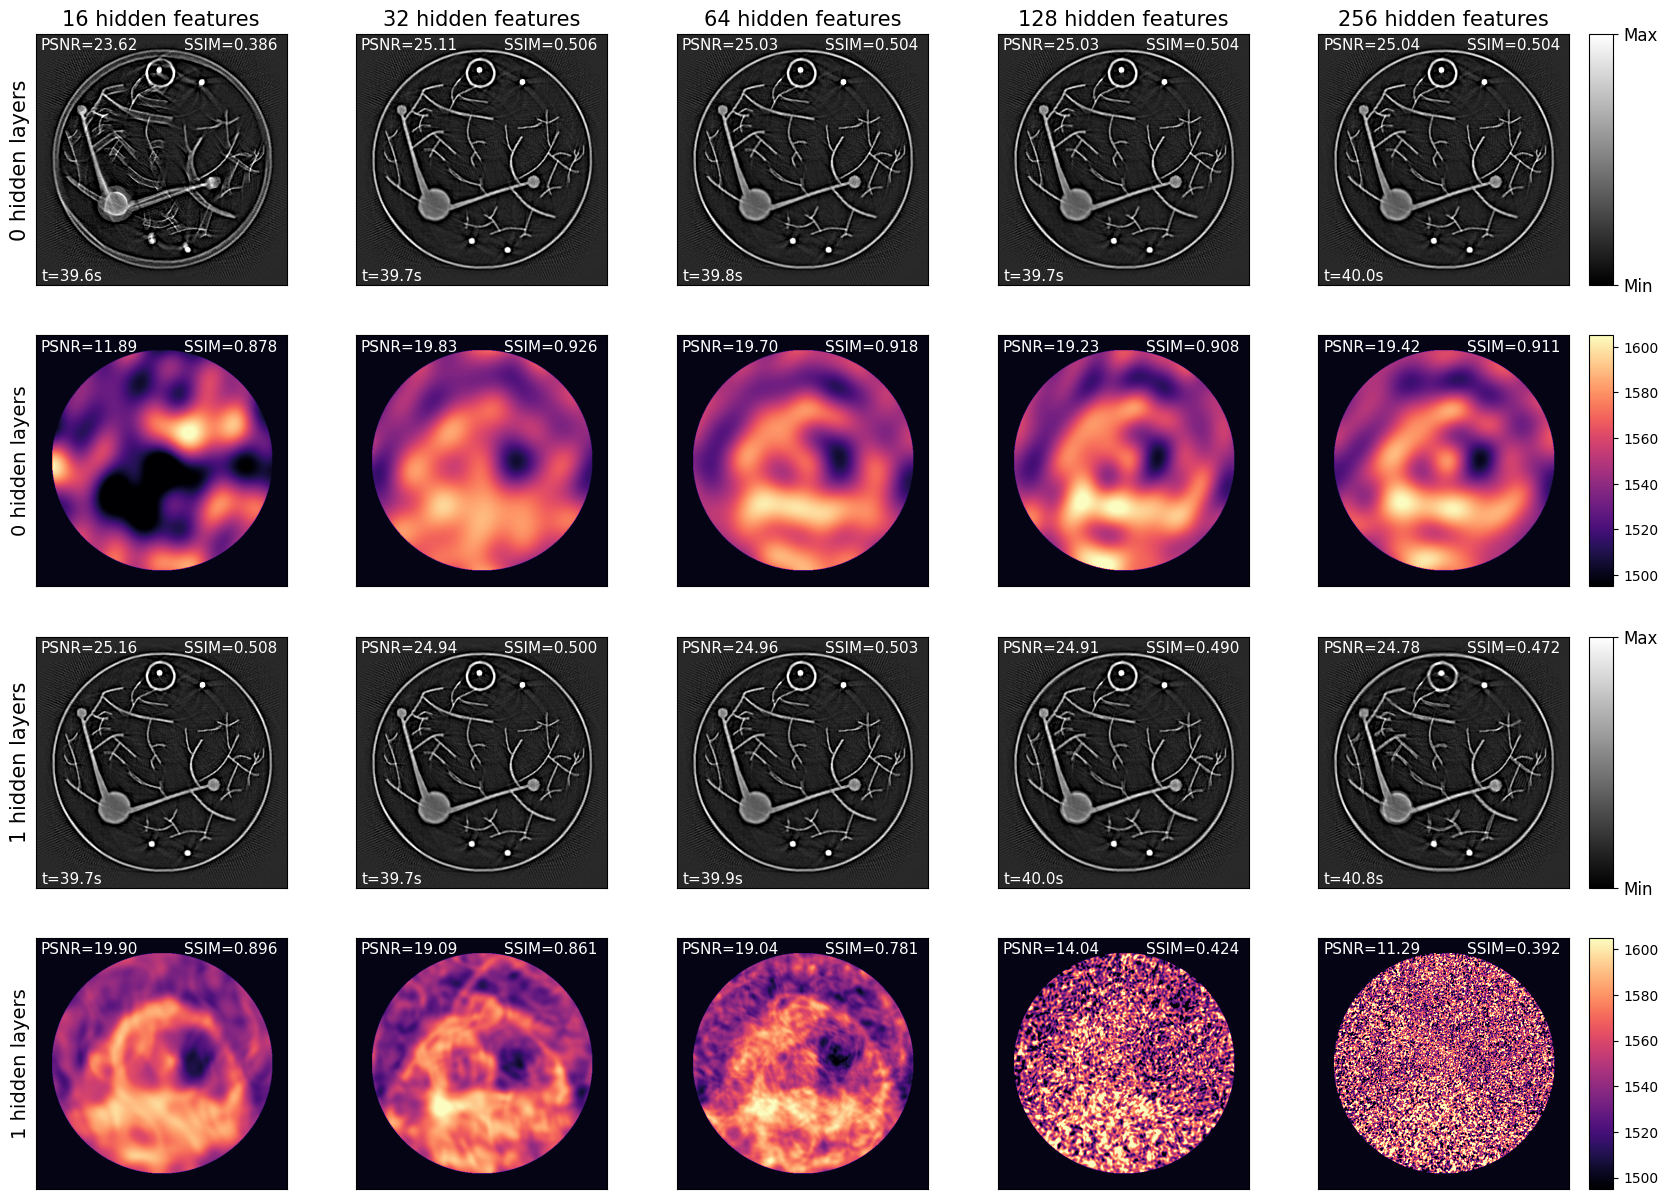

In [18]:
hls_list, hfs_list = [0, 1], [16, 32, 64, 128, 256]

fig = plt.figure(figsize=(20,15))
for i, hfs in enumerate(hfs_list):
    for j, hls in enumerate(hls_list):
        # params = '{}delays_{}lyrs_{}fts_TV={:.1e}_{}epochs_bs={}_lr={:.1e}'.format(32, hls, hfs, 5e-5, 10, 64, 1e-3)
        params = f'{n_delays_df}delays_{hls}lyrs_{hfs}fts_{n_epochs_df}epochs_bs={bs_df}_lr={lr_nf_df:.1e}'
        ip_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'IP_rec.mat'))
        sos_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'SOS_rec.mat'))
        ip_rec = standardize(ip_rec)
        log = load_log(os.path.join(results_path, 'NF-APACT', params, 'log.json'))
        ax = plt.subplot(2*len(hls_list),len(hfs_list),i+1+len(hfs_list)*2*j)
        plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
        plt.xticks([])
        plt.yticks([])
        plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
        plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
        plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
        if j == 0:
            plt.title('{} hidden features'.format(hfs), fontsize=15)
        if i == 0:
            plt.ylabel('{} hidden layers'.format(hls), fontsize=15)
        if (i+1) % len(hfs_list) == 0:
            cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
            cb = plt.colorbar(cax=cax, norm=norm_ip)
            cb.set_ticks([IP_max, IP_min])
            cb.set_ticklabels(['Max', 'Min'], fontsize=12)
        
        ax = plt.subplot(2*len(hls_list),len(hfs_list),i+1+len(hfs_list)*(1+2*j))
        plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
        plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
        plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('{} hidden layers'.format(hls), fontsize=14)
        if (i+1) % len(hfs_list) == 0:
            cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
            cb = plt.colorbar(cax=cax, norm=norm_sos)

#### TV Regularization.

In [19]:
# lam_list = [0.0, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4]

# fig = plt.figure(figsize=(22,7))
# results_path = os.path.join(RESULTS_DIR, 'numerical_full')
# for i, lam in enumerate(lam_list):
#     params =f'{32}delays_{1}lyrs_{32}fts' + ('_TV={:.1e}'.format(lam) if lam != 0 else '') + '_{}epochs_bs={}_lr={:.1e}'.format(15, 64, 1e-3)
#     ip_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'IP_rec.mat'))
#     sos_rec = load_mat(os.path.join(results_path, 'NF-APACT', params, 'SOS_rec.mat'))
#     ip_rec = standardize(ip_rec)
#     log = load_log(os.path.join(results_path, 'NF-APACT', params, 'log.json'))
#     ax = plt.subplot(2,len(lam_list),i+1)
#     plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
#     plt.axis('off')
#     plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
#     plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
#     plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
#     plt.title('$\lambda_{TV}$'+'={:.1e}'.format(lam), fontsize=15)

#     if (i+1) % len(lam_list) == 0:
#         cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
#         cb = plt.colorbar(cax=cax, norm=norm_ip)
#         cb.set_ticks([IP_max, IP_min])
#         cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
#     ax = plt.subplot(2,len(lam_list),i+1+len(lam_list))
#     plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
#     plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
#     plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
#     plt.axis('off')
#     if (i+1) % len(lam_list) == 0:
#         cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
#         cb = plt.colorbar(cax=cax, norm=norm_sos)

### Pixel Grid

In [20]:
lam_tv_df = 1.0e-4
lr_pg_df = 0.1
n_epochs_df = 30

Learning rate.

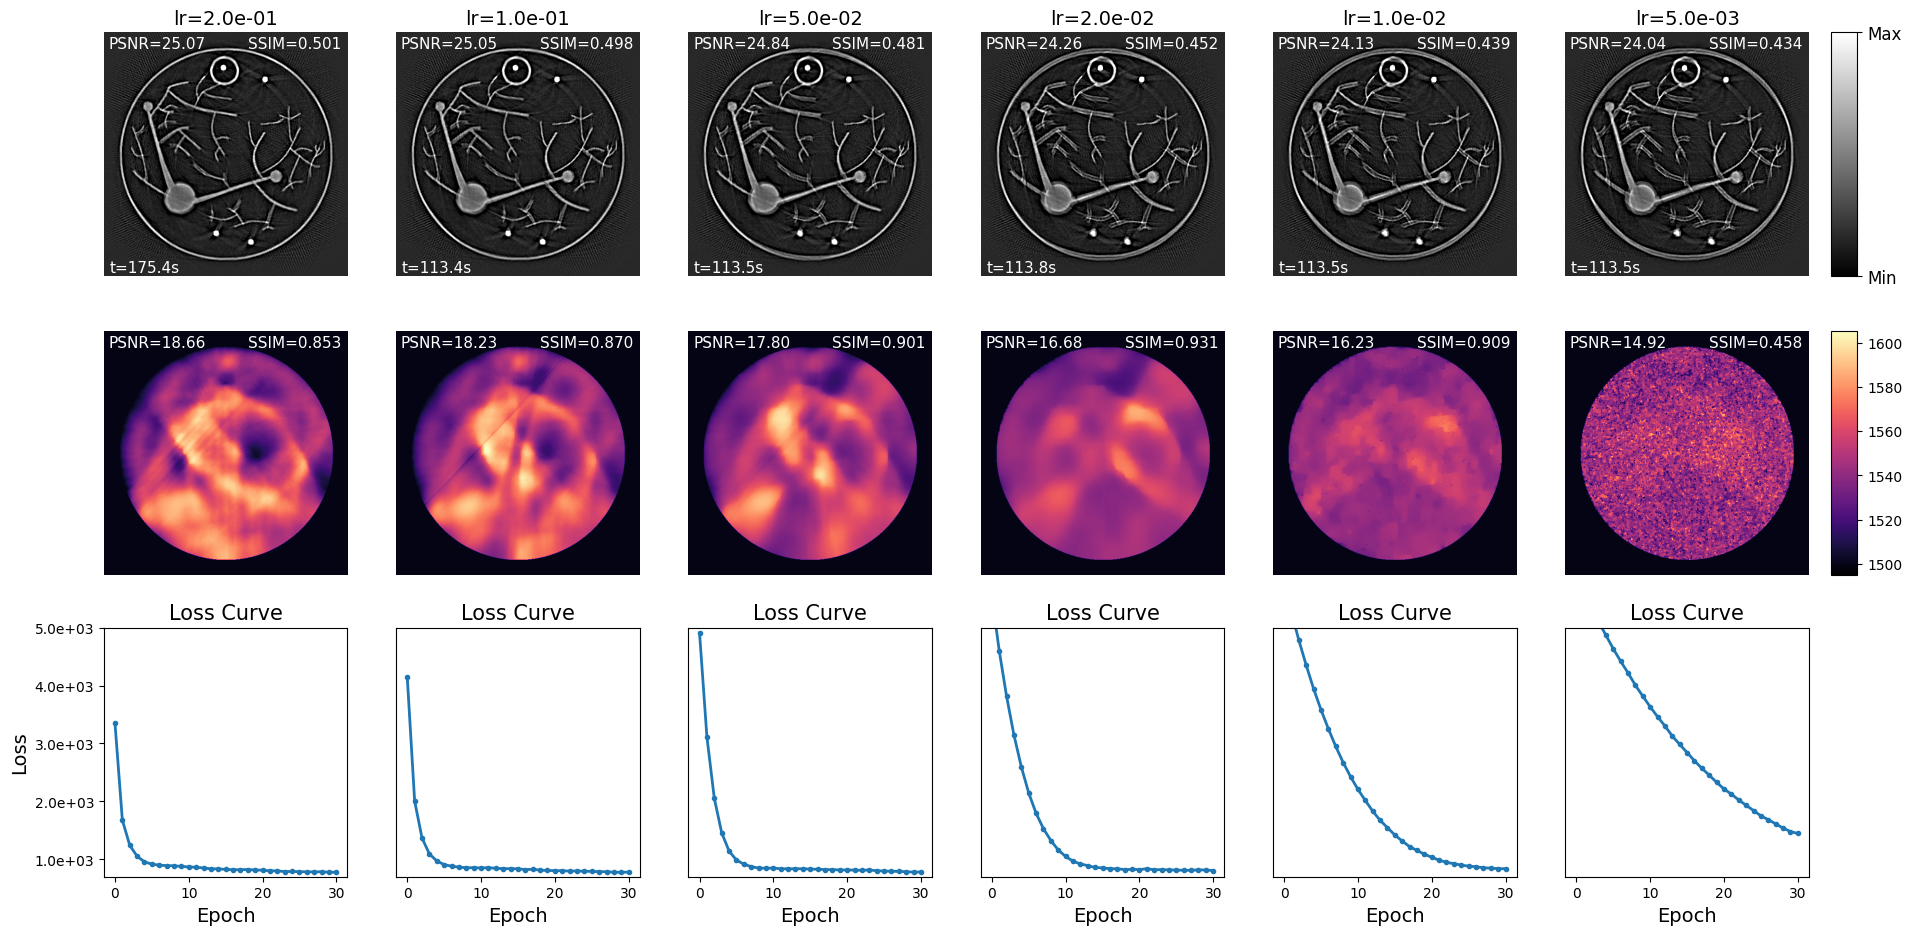

In [21]:
lr_list = [2e-1,1e-1,5e-2,2e-2,1e-2,5e-3]

fig = plt.figure(figsize=(22,11))
for idx, lr in enumerate(lr_list):
    params = f'{n_delays_df}delays_TV={lam_tv_df:.1e}_{30}epochs_bs={bs_df}_lr={lr:.1e}'
    ip_rec = load_mat(os.path.join(results_path, 'PG', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'PG', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'PG', params, 'log.json'))
    ax = plt.subplot(3,len(lr_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('lr={:.1e}'.format(lr), fontsize=14)
    if (idx+1) % len(lr_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(3,len(lr_list),idx+1+len(lr_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
    plt.axis('off')
    if (idx+1) % len(lr_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)
        
    ax = plt.subplot(3,len(lr_list),idx+1+2*len(lr_list))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    plt.plot(range(len(log['loss'])), log['loss'], '-o', markersize=3, linewidth=2, label='loss')
    plt.ylim([7e2, 5e3])
    plt.title("Loss Curve", fontsize=15)
    plt.xlabel("Epoch", fontsize=14)
    if idx == 0:
        plt.ylabel("Loss", fontsize=14)
    else:
        plt.yticks([],fontsize=9)

Number of delays.

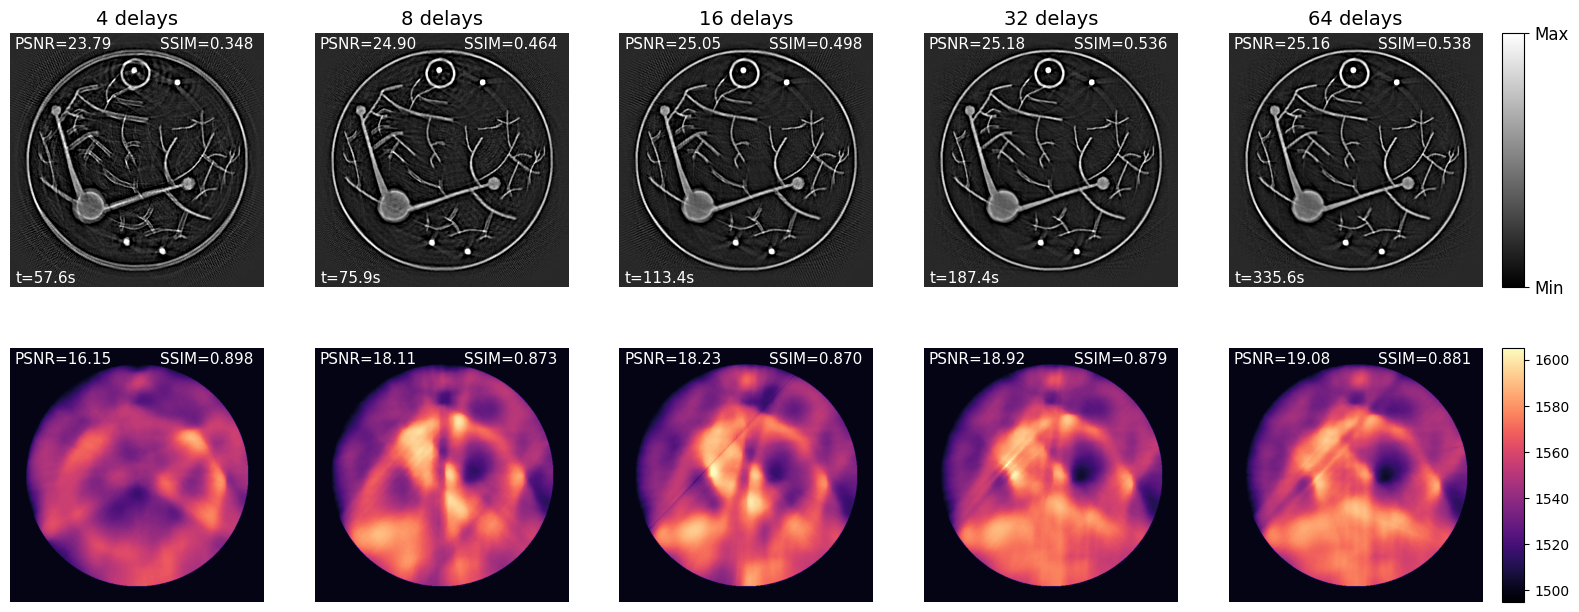

In [22]:
n_delays_list = [4, 8, 16, 32, 64]

fig = plt.figure(figsize=(19,7.5))
for idx, n_delays in enumerate(n_delays_list):
    params = f'{n_delays}delays_TV={lam_tv_df:.1e}_{n_epochs_df}epochs_bs={bs_df}_lr={lr_pg_df:.1e}'
    ip_rec = load_mat(os.path.join(results_path, 'PG', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'PG', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'PG', params, 'log.json'))
    ax = plt.subplot(2,len(n_delays_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('{} delays'.format(n_delays), fontsize=14)
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(2,len(n_delays_list),idx+1+len(n_delays_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
    plt.axis('off')
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)

TV regularization.

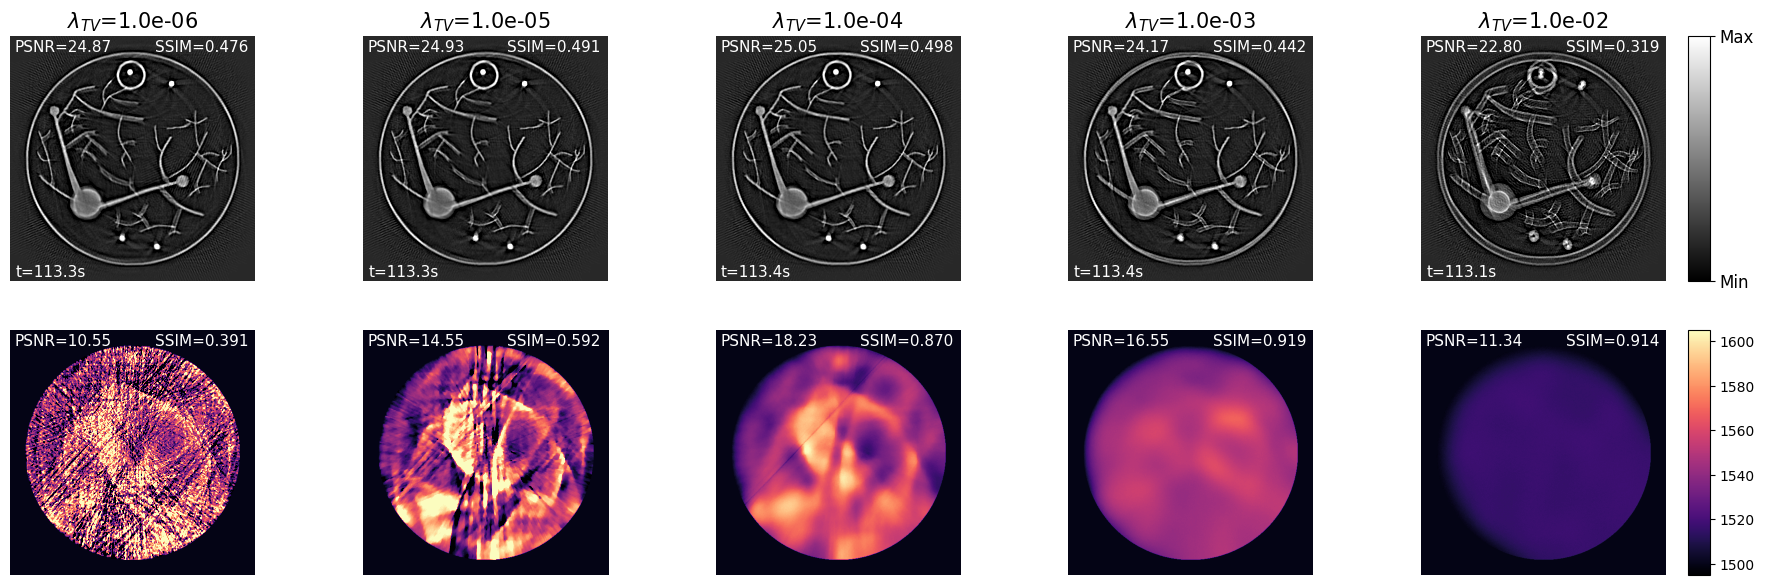

In [23]:
lam_list = [1e-6,1e-5,1e-4,1e-3,1e-2] # [2e-5,5e-5,1e-4,2e-4,5e-4,1e-3]

fig = plt.figure(figsize=(22,7))
for i, lam in enumerate(lam_list):
    params =f'{n_delays_df}delays_TV={lam:.1e}_{n_epochs_df}epochs_bs={bs_df}_lr={lr_pg_df:.1e}'
    ip_rec = load_mat(os.path.join(results_path, 'PG', params, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'PG', params, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'PG', params, 'log.json'))
    ax = plt.subplot(2,len(lam_list),i+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.1f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('$\lambda_{TV}$'+'={:.1e}'.format(lam), fontsize=15)

    if (i+1) % len(lam_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)
    
    ax = plt.subplot(2,len(lam_list),i+1+len(lam_list))
    plt.imshow(sos_rec, cmap='magma', norm=norm_sos)
    plt.text(s='PSNR={:.2f}'.format(psnr(sos_gt, sos_rec, data_range=data_range_sos)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(sos_gt, sos_rec, data_range=data_range_sos)), x=330, y=35, fontsize=11, color='white')
    plt.axis('off')
    if (i+1) % len(lam_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)

### Multi-channel Deconvolution

Number of delays.

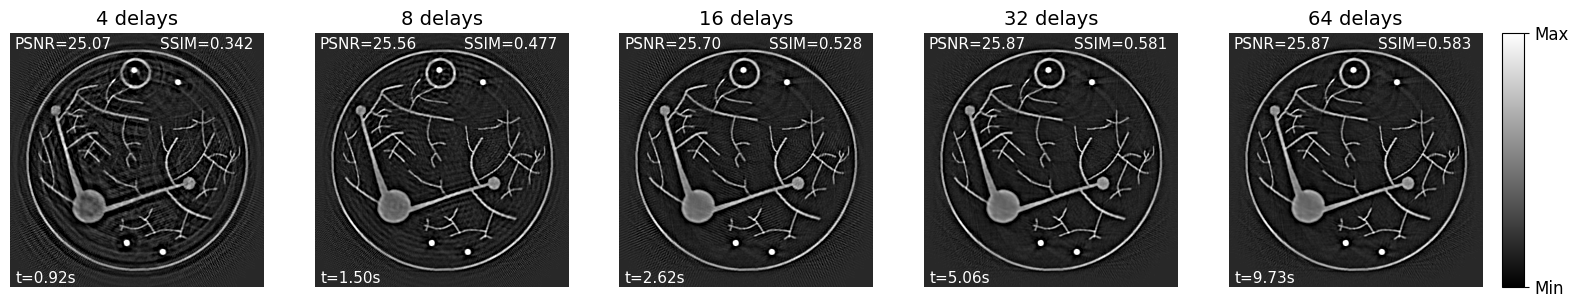

In [24]:
n_delays_list = [4, 8, 16, 32, 64]

fig = plt.figure(figsize=(19,4))
for idx, n_delays in enumerate(n_delays_list):
    params = f'{n_delays}delays_bs={bs_df}'
    ip_rec = load_mat(os.path.join(results_path, 'Deconv', params, 'IP_rec.mat'))
    ip_rec = standardize(ip_rec)
    log = load_log(os.path.join(results_path, 'Deconv', params, 'log.json'))
    ax = plt.subplot(1,len(n_delays_list),idx+1)
    plt.imshow(ip_rec, cmap='gray', norm=norm_ip)
    plt.axis('off')
    plt.text(s='PSNR={:.2f}'.format(psnr(ip_gt, ip_rec, data_range=data_range_ip)), x=10, y=35, fontsize=11, color='white')
    plt.text(s='SSIM={:.3f}'.format(ssim(ip_gt, ip_rec, data_range=data_range_ip)), x=330, y=35, fontsize=11, color='white')
    plt.text(s='t={:.2f}s'.format(log['time']), x=12, y=550, fontsize=11, color='white')
    plt.title('{} delays'.format(n_delays), fontsize=14)
    if (idx+1) % len(n_delays_list) == 0:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_ip)
        cb.set_ticks([IP_max, IP_min])
        cb.set_ticklabels(['Max', 'Min'], fontsize=12)